
# Challenge Problem 1 — Updated Plan Runner (Sergio)

> This notebook is for Challenge Problem 1 (2.155 ML & AI for Design Engineering @ MIT).
> It follows the same code style and class usage from the starter and advanced notebooks:
> - Set JAX to CPU, deterministic seeds
> - Use `LINKS` modules: `MechanismVisualizer`, `MechanismSolver`, `CurveEngine`, `Tools`, `DifferentiableTools`
> - Use `pymoo` with NSGA-II for GA
>
> **Outline**
> 1. Environment Setup (imports, seeds, device)
> 2. Load Resources (target curves, starter mechanism) + Visualize targets
> 3. Helper Utilities (validation, random mechanism generation, diversity selection, HV greedy selection)
> 4. **A — Bulk Seeding** (random valid mechanisms → preprocessed → valid bank per curve)
> 5. **B1 — GA Track** (Starter positions-only / Advanced mixed-variable placeholder)
> 6. **B2 — GD Refinement Track** (multi-objective GD on positions using both Distance & Material gradients)
> 7. **C — Pool, De-duplicate & Select Top-1000** (diversity-aware + HV-greedy)
> 8. Evaluation & Reporting (HV per curve, Pareto plots, alignment checks)
> 9. Save Results & Submission Packaging
>
> **How to use**
> - Run from top to bottom for each target curve (or loop over all 6).
> - All hyperparameters are grouped in one place. Keep constraints **exactly** as in the starter/advanced notebooks.



## 1) Environment Setup
Make execution deterministic and import the same modules used in the provided notebooks.


In [1]:

import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Tuple, Dict, Any, List

# deterministic random numbers
np.random.seed(0)
random.seed(0)

# LINKS modules (same as in the notebooks)
from LINKS.Visualization import MechanismVisualizer
from LINKS.Kinematics import MechanismSolver
from LINKS.Geometry import CurveEngine
from LINKS.Optimization import Tools, DifferentiableTools

# pymoo for GA and HV
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize
from pymoo.indicators.hv import HV

# Global configs
DEVICE = 'cpu'  # 'cpu' or 'gpu' if available in your setup
RUN_STAMP = "{stamp}".format(stamp=np.datetime64('now')).replace(":", "-")

# Visualizer / Solver / Curve engine
visualizer = MechanismVisualizer()
solver = MechanismSolver(device=DEVICE)
curve_processor = CurveEngine(normalize_scale=False, device=DEVICE)

# Optimization tools
optimization_tools = Tools(device=DEVICE)
optimization_tools.compile()  # compile for speed
gradient_tools = DifferentiableTools(device=DEVICE)
gradient_tools.compile()      # compile for speed

print("Setup complete. Device:", DEVICE)


Setup complete. Device: cpu



## 2) Load Resources & Visualize Target Curves
`target_curves.npy` and `starter_mechanism.npy` are provided in the repository.


Loaded starter_mechanism.npy


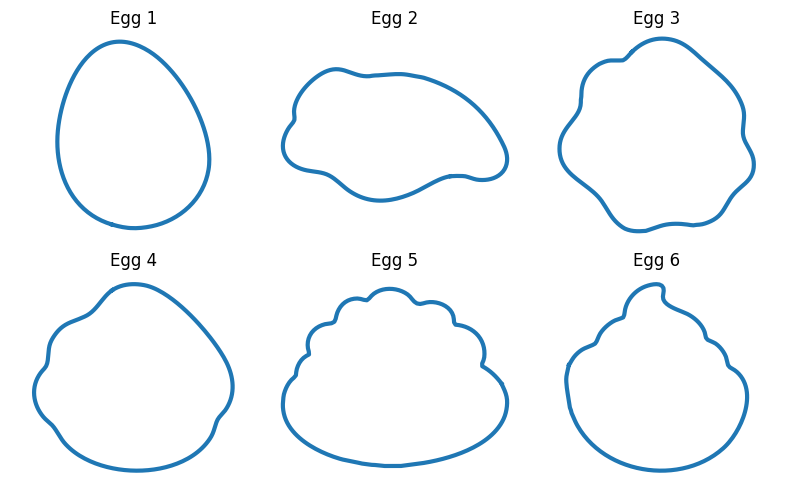

In [2]:

# Load target curves
target_curves = np.load('target_curves.npy')

# Optional: Load starter mechanism (useful for positions-only GA seeding)
try:
    starter_mech = np.load('starter_mechanism.npy', allow_pickle=True).item()
    print("Loaded starter_mechanism.npy")
except Exception as e:
    starter_mech = None
    print("Could not load starter_mechanism.npy:", e)

# Plot all target curves
fig, axs = plt.subplots(2, 3, figsize=(8, 5))
for i in range(6):
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]
    axs[i // 3, i % 3].plot(x_coords, y_coords, linewidth=3)
    axs[i // 3, i % 3].set_title(f'Egg {i + 1}')
    axs[i // 3, i % 3].axis('equal')
    axs[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()



## 3) Helper Utilities
Validation helpers, random mechanism generation (fallback if no built-in randomizer), diversity selection, and HV-greedy selection.


In [3]:

# Constraints (MUST MATCH notebooks)
DISTANCE_MAX = 0.75
MATERIAL_MAX = 10.0
JOINTS_MAX = 20
BOUNDS_L = 0.0
BOUNDS_U = 5.0

REF_POINT = np.array([DISTANCE_MAX, MATERIAL_MAX], dtype=float)

def is_connected(edges: np.ndarray, N: int) -> bool:
    """Simple BFS connectivity over undirected graph."""
    if N == 0:
        return False
    adj = [[] for _ in range(N)]
    for u, v in edges:
        if u < 0 or v < 0 or u >= N or v >= N:
            return False
        adj[u].append(v)
        adj[v].append(u)
    seen = set([0])
    stack = [0]
    while stack:
        u = stack.pop()
        for w in adj[u]:
            if w not in seen:
                seen.add(w)
                stack.append(w)
    return len(seen) == N

def validate_mechanism(x0: np.ndarray,
                       edges: np.ndarray,
                       fixed_joints: np.ndarray,
                       motor: np.ndarray) -> bool:
    """Basic structural checks before simulation."""
    N = x0.shape[0]
    if N > JOINTS_MAX:
        return False
    if edges.ndim != 2 or edges.shape[1] != 2:
        return False
    if not is_connected(edges, N):
        return False
    # Motor must reference a valid edge
    a, b = int(motor[0]), int(motor[1])
    if a < 0 or b < 0 or a >= N or b >= N:
        return False
    # Ensure undirected edge presence
    if not any(((e[0] == a and e[1] == b) or (e[0] == b and e[1] == a)) for e in edges):
        return False
    # Fixed joints must be within range
    if np.any(fixed_joints < 0) or np.any(fixed_joints >= N):
        return False
    return True

def eval_distance_material(x0: np.ndarray,
                           edges: np.ndarray,
                           fixed_joints: np.ndarray,
                           motor: np.ndarray,
                           target_curve: np.ndarray,
                           target_idx=None):
    """Wrapper around Tools to get (distance, material)."""
    d, m = optimization_tools(x0, edges, fixed_joints, motor, target_curve, target_idx=target_idx)
    return float(d), float(m)

def is_valid_objectives(distance: float, material: float) -> bool:
    return (distance <= DISTANCE_MAX) and (material <= MATERIAL_MAX)

def farthest_point_selection(points: np.ndarray, k: int) -> np.ndarray:
    """Farthest-point sampling in objective space to maximize spread.
    points: (N, 2) for (distance, material).
    Returns indices of selected points.
    """
    n = points.shape[0]
    if k >= n:
        return np.arange(n)
    # Normalize to [0,1] box using ref point as max
    eps = 1e-12
    norm = np.clip(points / (REF_POINT + eps), 0.0, 1.0)
    # start with best distance+material sum
    start = np.argmin(norm.sum(axis=1))
    selected = [start]
    remaining = set(range(n)) - set(selected)
    dist_cache = np.linalg.norm(norm - norm[start], axis=1)
    while len(selected) < k and remaining:
        # pick point that maximizes min distance to selected
        min_d = np.min(np.vstack([np.linalg.norm(norm - norm[idx], axis=1) for idx in selected]), axis=0)
        min_d[list(selected)] = -1.0
        nxt = int(np.argmax(min_d))
        selected.append(nxt)
        remaining.discard(nxt)
    return np.array(selected, dtype=int)

def hv_greedy_selection(points: np.ndarray, k: int, ref_point: np.ndarray = REF_POINT) -> np.ndarray:
    """Greedy HV selection from a set of 2D points (minimization objectives).
    points: (N,2) objective values
    Returns indices of selected points (size <= k).
    """
    hv = HV(ref_point=ref_point)
    n = points.shape[0]
    if k >= n:
        return np.arange(n)
    selected = []
    best_set = np.empty((0, 2), dtype=float)
    remaining = list(range(n))
    # seed: point with best HV alone
    gains = []
    for idx in remaining:
        g = hv(np.array([points[idx]], dtype=float))
        gains.append((g, idx))
    gains.sort(reverse=True, key=lambda t: t[0])
    selected.append(gains[0][1])
    best_set = np.vstack([best_set, points[selected[-1]]])
    remaining.remove(selected[-1])

    # add greedily
    while len(selected) < k and remaining:
        best_gain = -np.inf
        best_idx = None
        current_hv = hv(best_set)
        for idx in remaining:
            cand_set = np.vstack([best_set, points[idx]])
            gain = hv(cand_set) - current_hv
            if gain > best_gain:
                best_gain = gain
                best_idx = idx
        if best_idx is None:
            break
        selected.append(best_idx)
        best_set = np.vstack([best_set, points[best_idx]])
        remaining.remove(best_idx)

    return np.array(selected, dtype=int)

def deduplicate_by_objectives(points: np.ndarray, tol: float = 1e-4) -> np.ndarray:
    """Remove near-duplicate objective points (distance, material) within tol.
    Returns indices to keep.
    """
    keep = []
    used = np.zeros(points.shape[0], dtype=bool)
    for i in range(points.shape[0]):
        if used[i]:
            continue
        keep.append(i)
        di = np.abs(points - points[i])
        used |= (di[:,0] <= tol) & (di[:,1] <= tol)
    return np.array(keep, dtype=int)

def pack_mechanism(x0, edges, fixed_joints, motor, target_idx=None) -> Dict[str, Any]:
    mech = {
        "x0": np.array(x0, dtype=float),
        "edges": np.array(edges, dtype=int),
        "fixed_joints": np.array(fixed_joints, dtype=int),
        "motor": np.array(motor, dtype=int),
    }
    if target_idx is not None:
        mech["target_idx"] = int(target_idx)
    return mech

# --- Random mechanism generation (fallback) ---
def random_connectivity_upper_tri(N: int, edge_prob: float = 0.25) -> np.ndarray:
    """Generate a symmetric 0/1 connectivity matrix with zero diagonal (upper-tri sampling)."""
    C = np.zeros((N, N), dtype=int)
    for i in range(N):
        for j in range(i+1, N):
            C[i, j] = 1 if (random.random() < edge_prob) else 0
    C = C + C.T
    np.fill_diagonal(C, 0)
    # ensure at least a simple spanning backbone
    for i in range(1, N):
        C[i-1, i] = 1
        C[i, i-1] = 1
    return C

def edges_from_connectivity(C: np.ndarray) -> np.ndarray:
    es = []
    N = C.shape[0]
    for i in range(N):
        for j in range(i+1, N):
            if C[i, j] == 1:
                es.append([i, j])
    return np.array(es, dtype=int)

def sample_random_mechanism(N: int,
                            bounds: Tuple[float, float] = (BOUNDS_L, BOUNDS_U),
                            edge_prob: float = 0.25,
                            fixed_mode: str = "two_left",
                            motor_pair: Tuple[int, int] = (0, 2)) -> Dict[str, Any]:
    """Fallback: generate a random mechanism with N nodes.
    - Positions uniform in [L, U]
    - Connectivity via symmetric upper-tri matrix + backbone
    - Two fixed joints by default at indices 0 and 1
    - Motor defaults to (0,2), which is usually an existing edge due to backbone
    """
    L, U = bounds
    x0 = np.random.uniform(L + 0.1, U - 0.1, size=(N, 2))
    C = random_connectivity_upper_tri(N, edge_prob=edge_prob)
    edges = edges_from_connectivity(C)

    if fixed_mode == "two_left":
        fixed_joints = np.array([0, 1], dtype=int)
    else:
        fixed_joints = np.array(sorted(random.sample(range(N), k=2)), dtype=int)

    motor = np.array(list(motor_pair), dtype=int)
    mech = pack_mechanism(x0, edges, fixed_joints, motor, target_idx=None)
    return mech

print("Utilities ready.")


Utilities ready.



## 4) A — Bulk Seeding (diverse, valid starts)
Generate a large pool of random mechanisms for a chosen target curve, evaluate, and keep only valid ones.
We also apply basic preprocessing (connectivity check, coarse filtering, duplicate culling).


In [10]:
# === Hyperparameters (edit here) ===
TARGET_INDICES = [0]                 # test one curve (0..5)
TARGET_SEEDS   = 100                 # how many structurally valid seeds to collect for GA init
N_RANGE        = [7, 8, 9, 10, 12, 14]
EDGE_PROB      = 0.25
DUP_TOL        = 1e-4

# Progress settings
PRINT_EVERY_TRIES = 10              # print every N attempts
PRINT_EVERY_KEEP  = 1               # print every N valids

from LINKS.Optimization import MechanismRandomizer
randomizer = MechanismRandomizer(min_size=min(N_RANGE), max_size=max(N_RANGE), device=DEVICE)

seed_banks = {ti: [] for ti in TARGET_INDICES}
seed_objectives = {ti: [] for ti in TARGET_INDICES}

import time, numpy as np, random

# ---- Global counters across all curves in this run ----
TOTAL_TRIED = 0
TOTAL_VALID = 0
RUN_T0 = time.time()

for ti in TARGET_INDICES:
    target_curve = np.array(target_curves[ti])

    # Per-curve counters
    tried = 0
    kept  = 0
    t0 = time.time()

    print(f"[Seeding] Target curve idx={ti} | Goal valid={TARGET_SEEDS}")
    while kept < TARGET_SEEDS:
        tried += 1
        TOTAL_TRIED += 1

        N = random.choice(N_RANGE)
        mech = randomizer(n=N)
        x0 = mech['x0']; edges = mech['edges']; fixed_joints = mech['fixed_joints']; motor = np.array([0,1], dtype=int)

        # Always print every PRINT_EVERY_TRIES attempts
        if tried % PRINT_EVERY_TRIES == 0:
            elapsed = time.time() - t0
            rate_curve = tried / max(elapsed, 1e-9)
            run_elapsed = time.time() - RUN_T0
            rate_total = TOTAL_TRIED / max(run_elapsed, 1e-9)
            hit_curve  = kept / max(tried, 1)
            hit_total  = TOTAL_VALID / max(TOTAL_TRIED, 1)
            print(f"[Progress] Tried={tried} | Valid={kept} | Hit={100*hit_curve:.2f}% | Rate={rate_curve:.1f} mech/s "
                  f"|| TOTAL Tried={TOTAL_TRIED} | Valid={TOTAL_VALID} | Hit={100*hit_total:.2f}% | Rate={rate_total:.1f} mech/s")

        # Structural validation only
        if not validate_mechanism(x0, edges, fixed_joints, motor):
            continue

        # Keep structurally valid seed
        mech['motor'] = motor
        seed_banks[ti].append(mech)

        # (Optional) evaluate objectives for info/plots (no filtering by these)
        d, m = eval_distance_material(x0, edges, fixed_joints, motor, target_curve, target_idx=None)
        seed_objectives[ti].append([d, m])

        kept += 1
        TOTAL_VALID += 1

        # Print every PRINT_EVERY_KEEP new valids
        if kept % PRINT_EVERY_KEEP == 0:
            elapsed = time.time() - t0
            rate_curve = tried / max(elapsed, 1e-9)
            run_elapsed = time.time() - RUN_T0
            rate_total = TOTAL_TRIED / max(run_elapsed, 1e-9)
            hit_curve  = kept / max(tried, 1)
            hit_total  = TOTAL_VALID / max(TOTAL_TRIED, 1)
            print(f"[Valid+] Tried={tried} | Valid={kept}/{TARGET_SEEDS} | Hit={100*hit_curve:.2f}% | Rate={rate_curve:.1f} mech/s "
                  f"|| TOTAL Tried={TOTAL_TRIED} | Valid={TOTAL_VALID} | Hit={100*hit_total:.2f}% | Rate={rate_total:.1f} mech/s")

    # Curve summary
    seed_objectives[ti] = np.array(seed_objectives[ti], dtype=float)
    elapsed = time.time() - t0
    rate_curve = tried / max(elapsed, 1e-9)
    hit_curve  = kept / max(tried, 1)
    print(f"[Summary curve ti={ti}] Tried={tried} | Valid={kept} | Elapsed={elapsed:.1f}s | "
          f"Rate={rate_curve:.1f} mech/s | Hit={100*hit_curve:.2f}%")

    # Optional objective-space de-dup
    if len(seed_banks[ti]) > 0 and seed_objectives[ti].size:
        keep_idx = deduplicate_by_objectives(seed_objectives[ti], tol=DUP_TOL)
        seed_banks[ti] = [seed_banks[ti][k] for k in keep_idx]
        seed_objectives[ti] = seed_objectives[ti][keep_idx]
        print(f"[Dedup ti={ti}] Kept after dedup: {len(seed_banks[ti])}")

# Final run summary
RUN_ELAPSED = time.time() - RUN_T0
RATE_TOTAL = TOTAL_TRIED / max(RUN_ELAPSED, 1e-9)
HIT_TOTAL  = TOTAL_VALID / max(TOTAL_TRIED, 1)
print(f"[Run Summary] TOTAL Tried={TOTAL_TRIED} | TOTAL Valid={TOTAL_VALID} | "
      f"Elapsed={RUN_ELAPSED:.1f}s | Rate={RATE_TOTAL:.1f} mech/s | Hit={100*HIT_TOTAL:.2f}%")


[Seeding] Target curve idx=0 | Goal valid=100
[Valid+] Tried=1 | Valid=1/100 | Hit=100.00% | Rate=0.3 mech/s || TOTAL Tried=1 | Valid=1 | Hit=100.00% | Rate=0.3 mech/s
[Valid+] Tried=2 | Valid=2/100 | Hit=100.00% | Rate=0.4 mech/s || TOTAL Tried=2 | Valid=2 | Hit=100.00% | Rate=0.4 mech/s
[Valid+] Tried=3 | Valid=3/100 | Hit=100.00% | Rate=0.5 mech/s || TOTAL Tried=3 | Valid=3 | Hit=100.00% | Rate=0.5 mech/s
[Valid+] Tried=4 | Valid=4/100 | Hit=100.00% | Rate=0.5 mech/s || TOTAL Tried=4 | Valid=4 | Hit=100.00% | Rate=0.5 mech/s
[Valid+] Tried=5 | Valid=5/100 | Hit=100.00% | Rate=0.5 mech/s || TOTAL Tried=5 | Valid=5 | Hit=100.00% | Rate=0.5 mech/s
[Valid+] Tried=6 | Valid=6/100 | Hit=100.00% | Rate=0.6 mech/s || TOTAL Tried=6 | Valid=6 | Hit=100.00% | Rate=0.6 mech/s
[Valid+] Tried=7 | Valid=7/100 | Hit=100.00% | Rate=0.6 mech/s || TOTAL Tried=7 | Valid=7 | Hit=100.00% | Rate=0.6 mech/s
[Valid+] Tried=8 | Valid=8/100 | Hit=100.00% | Rate=0.6 mech/s || TOTAL Tried=8 | Valid=8 | Hit=100.


## 5) B1 — GA Track
Two flavors:
- **Starter (positions-only):** optimize node positions for a fixed skeleton (uses `ElementwiseProblem` exactly like the starter notebook).
- **Advanced (mixed-variable):** positions + connectivity (placeholder here; use Advanced Starter code to define the mixed-variable problem).


In [19]:
# === GA hyperparameters (edit here) ===
POP_SIZE    = 100
N_GEN       = 100
SBX_ETA     = 3.0
SBX_PROB    = 1.0
PM_ETA      = 5.0          # a bit higher than 3 for better exploration
PM_PROB     = 0.15         # a bit higher than 0.05 for better exploration
INIT_JITTER = 0.02         # small perturbation to avoid identical-pop collapse

ga_elites     = {ti: [] for ti in TARGET_INDICES}
ga_elites_obj = {ti: [] for ti in TARGET_INDICES}

from pymoo.indicators.hv import HV
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

class MechanismSynthesisPositionsOnly(ElementwiseProblem):
    """Positions-only GA (Starter-style), constraints exactly as in the starter notebook."""
    def __init__(self, edges, fixed_joints, motor, target_curve, N_nodes):
        super().__init__(n_var=N_nodes*2, n_obj=2, n_constr=2,
                         xl=BOUNDS_L, xu=BOUNDS_U, elementwise_evaluation=True)
        self.edges = edges
        self.fixed_joints = fixed_joints
        self.motor = motor
        self.target_curve = target_curve
        self.N = N_nodes

    def _evaluate(self, x, out, *args, **kwargs):
        x0 = np.array(x).reshape(self.N, 2)
        d, m = optimization_tools(x0, self.edges, self.fixed_joints, self.motor, self.target_curve, target_idx=None)
        out["F"] = np.array([d, m], dtype=float)
        # EXACT same hard constraints used by the course notebooks:
        out["G"] = out["F"] - np.array([DISTANCE_MAX, MATERIAL_MAX], dtype=float)

def run_positions_only_ga_for_curve(target_idx: int,
                                    base_mech: Dict[str, Any],
                                    pop_size: int = POP_SIZE,
                                    n_gen: int = N_GEN,
                                    init_jitter: float = INIT_JITTER):
    """Starter-style GA with jittered init to avoid duplicates + pymoo verbose table."""
    edges = base_mech['edges']
    fixed_joints = base_mech['fixed_joints']
    motor = base_mech['motor']
    x0 = base_mech['x0']
    N_nodes = x0.shape[0]
    target_curve = np.array(target_curves[target_idx])

    problem = MechanismSynthesisPositionsOnly(edges, fixed_joints, motor, target_curve, N_nodes=N_nodes)

    # Warmup (so the first long eval doesn't feel like a hang)
    print(f"[Curve {target_idx+1}] Warmup eval...", flush=True)
    t0 = time.time()
    d0, m0 = optimization_tools(x0, edges, fixed_joints, motor, target_curve, target_idx=None)
    print(f"[Curve {target_idx+1}] Warmup done in {time.time()-t0:.2f}s (d={d0:.4f}, m={m0:.4f})", flush=True)

    # Init population: starter x0 duplicated + light jitter (then clip to bounds)
    base = x0.flatten()
    X = np.tile(base, (pop_size, 1))
    if init_jitter and init_jitter > 0.0:
        X += np.random.normal(0.0, init_jitter, size=X.shape)
    X = np.clip(X, BOUNDS_L, BOUNDS_U)

    algorithm = NSGA2(
        pop_size=pop_size,
        sampling=X,  # numpy array sampling is fine
        crossover=SBX(prob=SBX_PROB, eta=SBX_ETA),
        mutation=PolynomialMutation(eta=PM_ETA, prob=PM_PROB),
        eliminate_duplicates=True   # same as notebook; jitter prevents collapse
    )

    # START banner + let pymoo print its canonical table
    print(f"[Curve {target_idx+1}] Starting positions-only GA (pop={pop_size}, gens={n_gen}, jitter={init_jitter})", flush=True)
    print("="*90, flush=True)

    res = minimize(problem,
                   algorithm,
                   ('n_gen', n_gen),
                   verbose=True,          # <-- this prints the table every gen, like the class code
                   save_history=False,
                   seed=0)

    print("="*90, flush=True)

    # End-of-run summary like the notebooks
    Xsol = res.X if res.X is not None else np.empty((0, N_nodes*2))
    Fsol = res.F if res.F is not None else np.empty((0, 2))
    if Xsol.size == 0 or Fsol.size == 0:
        print(f"[Curve {target_idx+1}] Did Not Find Solutions!!", flush=True)
        return [], np.empty((0, 2))

    best_d, best_m = float(Fsol[:, 0].min()), float(Fsol[:, 1].min())
    print(f"[Curve {target_idx+1}] Summary: best distance={best_d:.4f}, best material={best_m:.4f}", flush=True)

    valid_mask = (Fsol[:, 0] <= DISTANCE_MAX) & (Fsol[:, 1] <= MATERIAL_MAX)
    valid_idx = np.where(valid_mask)[0]

    if valid_idx.size > 0:
        hv = HV(ref_point=np.array([DISTANCE_MAX, MATERIAL_MAX], dtype=float))
        hv_val = float(hv(Fsol[valid_idx]))
        print(f"[Curve {target_idx+1}] Feasible solutions: {valid_idx.size} | HV={hv_val:.6f}", flush=True)
    else:
        print(f"[Curve {target_idx+1}] Feasible solutions: 0 (Did Not Find Solutions!!)", flush=True)

    elites = []
    for idx in valid_idx:
        x0_sol = Xsol[idx].reshape(N_nodes, 2)
        elites.append(pack_mechanism(x0_sol, edges, fixed_joints, motor, target_idx=None))

    print(f"[Curve {target_idx+1}] Valid elites collected = {len(elites)}", flush=True)
    return elites, Fsol[valid_idx]

# --- Driver loop ---
for ti in TARGET_INDICES:
    print(f"\n=== GA (positions-only) for Curve {ti+1} ===", flush=True)
    if starter_mech is None:
        print("[Driver] No starter_mechanism.npy available; skipping GA for this curve.", flush=True)
        continue

    elites, F = run_positions_only_ga_for_curve(
        target_idx=ti,
        base_mech=starter_mech,
        pop_size=POP_SIZE,
        n_gen=N_GEN,
        init_jitter=INIT_JITTER
    )
    ga_elites[ti].extend(elites)
    if F.size:
        ga_elites_obj[ti].extend(F.tolist())

    print(f"[Driver] Curve {ti+1}: collected={len(elites)} elites | total so far={len(ga_elites[ti])}", flush=True)


# --- Placeholder: Advanced mixed-variable GA (positions + connectivity) ---
# NOTE: Use the Advanced Starter Notebook's mixed-variable problem class here if desired.
# After running, extend ga_elites[ti] and ga_elites_obj[ti] with additional valid elites.



=== GA (positions-only) for Curve 1 ===
[Curve 1] Warmup eval...


[Curve 1] Warmup done in 1.74s (d=2.1256, m=14.2079)
[Curve 1] Starting positions-only GA (pop=100, gens=100, jitter=0.02)


KeyboardInterrupt: 


## 6) B2 — GD Refinement Track (multi-objective on positions)
Refine GA elites by running gradient-based optimization on **positions** using `DifferentiableTools`.
We use both **Distance** and **Material** gradients via scalarization with rotating weights.


In [12]:

# === GD hyperparameters (edit here) ===
GD_ITERS = 50
GD_STEP = 0.01
SCALAR_WEIGHTS = [0.2, 0.5, 0.8]  # rotate these to emphasize Distance vs Material

gd_refined = {ti: [] for ti in TARGET_INDICES}
gd_refined_obj = {ti: [] for ti in TARGET_INDICES}

def project_positions(x0: np.ndarray, lo=BOUNDS_L, hi=BOUNDS_U) -> np.ndarray:
    return np.clip(x0, lo, hi)

def gd_refine_positions(mech: Dict[str, Any], target_curve: np.ndarray) -> Tuple[Dict[str, Any], Tuple[float, float]]:
    x0 = mech['x0'].copy()
    edges = mech['edges']
    fixed_joints = mech['fixed_joints']
    motor = mech['motor']

    # Multi-objective via scalarization loop
    for it in range(GD_ITERS):
        w = SCALAR_WEIGHTS[it % len(SCALAR_WEIGHTS)]
        d, m, d_grad_list, m_grad_list = gradient_tools(x0, edges, fixed_joints, motor, target_curve, target_idx=None)
        # grads come as a list of arrays per-node; stack to shape (N,2)
        dG = np.stack(d_grad_list, axis=0)
        mG = np.stack(m_grad_list, axis=0)
        grad = w * dG + (1.0 - w) * mG

        # freeze fixed joints
        mask = np.ones_like(x0, dtype=bool)
        mask[fixed_joints] = False

        # gradient descent step
        x0[mask] = x0[mask] - GD_STEP * grad[mask]

        # project back to bounds
        x0 = project_positions(x0)

    # final evaluation
    d, m = eval_distance_material(x0, edges, fixed_joints, motor, target_curve, target_idx=None)
    refined = pack_mechanism(x0, edges, fixed_joints, motor, target_idx=None)
    return refined, (d, m)

# Run GD refinement on top GA elites
for ti in TARGET_INDICES:
    target_curve = np.array(target_curves[ti])
    elites = ga_elites[ti]
    if len(elites) == 0:
        print(f"Curve {ti+1}: No GA elites to refine.")
        continue
    for mech in elites:
        refined, (d, m) = gd_refine_positions(mech, target_curve)
        if is_valid_objectives(d, m):
            gd_refined[ti].append(refined)
            gd_refined_obj[ti].append([d, m])
    print(f"Curve {ti+1}: GD refined valid = {len(gd_refined[ti])}")


Curve 1: No GA elites to refine.



## 7) C — Pool, De-duplicate & Select Top-1000 (per curve)
Combine seed bank + GA elites + GD refined; remove duplicates; select **top-1000** via diversity-aware + HV-greedy.


In [ ]:

TOP_K_SUBMIT = 1000

selected_per_curve = {}
selected_obj_per_curve = {}

for ti in TARGET_INDICES:
    objs = []
    mechs = []

    # Seeds
    if ti in seed_banks:
        for mech, (d, m) in zip(seed_banks[ti], seed_objectives[ti] if len(seed_objectives[ti])>0 else []):
            mechs.append(mech)
            objs.append([d, m])

    # GA elites
    for mech, (d, m) in zip(ga_elites[ti], ga_elites_obj[ti] if len(ga_elites_obj[ti])>0 else []):
        mechs.append(mech)
        objs.append([d, m])

    # GD refined
    for mech, (d, m) in zip(gd_refined[ti], gd_refined_obj[ti] if len(gd_refined_obj[ti])>0 else []):
        mechs.append(mech)
        objs.append([d, m])

    if len(mechs) == 0:
        print(f"Curve {ti+1}: No candidates to select from.")
        selected_per_curve[ti] = []
        selected_obj_per_curve[ti] = np.empty((0,2))
        continue

    objs = np.array(objs, dtype=float)

    # De-duplicate near-identical objective points
    keep_idx = deduplicate_by_objectives(objs, tol=1e-5)
    objs = objs[keep_idx]
    mechs = [mechs[i] for i in keep_idx]

    # Diversity-aware pruning to (at most) 2*TOP_K_SUBMIT to keep HV greedy fast
    if len(mechs) > 2*TOP_K_SUBMIT:
        idx_div = farthest_point_selection(objs, k=2*TOP_K_SUBMIT)
        objs = objs[idx_div]
        mechs = [mechs[i] for i in idx_div]

    # HV-greedy selection to TOP_K_SUBMIT
    sel_idx = hv_greedy_selection(objs, k=min(TOP_K_SUBMIT, len(mechs)), ref_point=REF_POINT)
    selected_per_curve[ti] = [mechs[i] for i in sel_idx]
    selected_obj_per_curve[ti] = objs[sel_idx]

    print(f"Curve {ti+1}: Selected {len(selected_per_curve[ti])} for submission (of {len(mechs)} candidates)." )



## 8) Evaluation & Reporting
Quick hypervolume (HV) summary per curve and Pareto scatter plots; also optional alignment checks.


In [ ]:

# HV per curve
hv_indicator = HV(ref_point=REF_POINT)
hv_scores = {}

for ti in TARGET_INDICES:
    F = selected_obj_per_curve.get(ti, np.empty((0,2)))
    if F.shape[0] == 0:
        hv_scores[ti] = 0.0
    else:
        hv_scores[ti] = float(hv_indicator(F))

print("Hypervolume per curve (ref point {}):".format(REF_POINT.tolist()))
for ti in TARGET_INDICES:
    print(f"  Curve {ti+1}: HV = {hv_scores[ti]:.6f} (count={selected_obj_per_curve.get(ti, np.empty((0,2))).shape[0]})")

# Scatter plots of Pareto points
cols = 3
rows = int(np.ceil(len(TARGET_INDICES) / cols))
plt.figure(figsize=(cols*4, rows*3.5))
for idx, ti in enumerate(TARGET_INDICES):
    plt.subplot(rows, cols, idx+1)
    F = selected_obj_per_curve.get(ti, np.empty((0,2)))
    if F.shape[0] > 0:
        plt.scatter(F[:,0], F[:,1], s=10)
    plt.axvline(DISTANCE_MAX, linestyle='--', linewidth=1)
    plt.axhline(MATERIAL_MAX, linestyle='--', linewidth=1)
    plt.title(f'Curve {ti+1} (n={F.shape[0]})')
    plt.xlabel('Distance')
    plt.ylabel('Material')
    plt.gca().invert_xaxis()  # sometimes helpful to visualize "better" to the right
plt.tight_layout()
plt.show()

# Optional: visualize alignment for a few selected mechanisms per curve
EXAMPLES_PER_CURVE = 3
for ti in TARGET_INDICES:
    target_curve = np.array(target_curves[ti])
    picks = selected_per_curve[ti][:EXAMPLES_PER_CURVE]
    print(f"\nCurve {ti+1} — visual checks for {len(picks)} examples:")
    for mech in picks:
        # Solve and visualize traced curve of the last joint by default
        sol = solver(mech['x0'], mech['edges'], mech['fixed_joints'], mech['motor'])
        traced_curve = sol[-1]  # default: last joint as "most complex"
        curve_processor.visualize_alignment(traced_curve, target_curve)
        curve_processor.visualize_comparison(traced_curve, target_curve)



## 9) Save Results & Submission Packaging
Save:
- Per-curve selected mechanisms (structures + positions)
- Objectives for quick reference
- A single `submission` object stub you can adapt to the course's `evaluate_submission` helper.


In [ ]:

import pathlib, json

outdir = pathlib.Path(f"results_{RUN_STAMP}")
outdir.mkdir(parents=True, exist_ok=True)

# Save per-curve mechanisms and objectives
for ti in TARGET_INDICES:
    mechs = selected_per_curve.get(ti, [])
    F = selected_obj_per_curve.get(ti, np.empty((0,2)))
    np.save(outdir / f"curve_{ti+1}_mechanisms.npy", np.array(mechs, dtype=object))
    np.save(outdir / f"curve_{ti+1}_objectives.npy", F)
print("Saved per-curve mechanism and objective arrays.")

# Build a submission stub (adjust keys to match the grader's expected format)
# Here we follow a simple structure: a dict mapping curve index -> list of mechanism dicts
submission = {f"curve_{ti+1}": selected_per_curve.get(ti, []) for ti in TARGET_INDICES}

# Save JSON (positions/arrays converted to lists for portability)
def jsonify_mech(m):
    return {
        "x0": m["x0"].tolist(),
        "edges": m["edges"].tolist(),
        "fixed_joints": m["fixed_joints"].tolist(),
        "motor": m["motor"].tolist(),
        **({"target_idx": int(m.get("target_idx"))} if ("target_idx" in m) else {})
    }

submission_json = {k: [jsonify_mech(m) for m in v] for k, v in submission.items()}
with open(outdir / "submission.json", "w") as f:
    json.dump(submission_json, f)

# Also save a numpy version if preferred by grader utilities
np.save(outdir / "submission.npy", np.array(submission, dtype=object))

print("Saved submission to:", outdir)
